#GAN - MNIST

##Imports

In [0]:

%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader



##Initialization

In [0]:

# Initialize Batch Size
batch_size = 64

# Load Dataset
train_dataset = datasets.MNIST(root='data', train=True, download =True, transform=transforms.ToTensor())

# Prepare the dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)


##Data Visualization

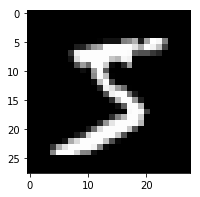

In [37]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
px = fig.add_subplot(111)
px.imshow(img, cmap='gray')

#GAN Model
##Discriminator


It is a linear classifier with 2 hidden layers. This network uses leaky ReLU as an activation function.
A leaky ReLU is a normal ReLU function but it return small non-zero value for negative inputs. We use leaky ReLU so gradients can backward propagate without hinderance.

Using a BCEWithLogitsLoss which combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable. Source: [Documentation](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
  
  def __init__(self, input_size, hidden_dim, output_size):
    super(Discriminator, self).__init__()
    
    # Layers
    self.conv1 = nn.Linear(input_size, hidden_dim*4)    # Input Layer
    self.conv2 = nn.Linear(hidden_dim*4, hidden_dim*2)
    self.conv3 = nn.Linear(hidden_dim*2, hidden_dim)
    self.conv4 = nn.Linear(hidden_dim, output_size)  # Final Layer
    
    # Dropout layer
    self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
      # Flatten image
      x = x.view(-1, 28*28)
      
      x = F.leaky_relu(self.conv1(x), 0.2)   # (input, negative_slope)
      x = self.dropout(x)
      x = F.leaky_relu(self.conv2(x), 0.2)
      x = self.dropout(x)
      x = F.leaky_relu(self.conv3(x), 0.2)
      x = self.dropout(x)
     
      # Final Layer
      output = self.conv4(x)
      
      return output
    

##Add Generator

Works like the Discriminator but use tanh as an activation function in the output layer.
Generator works best when tanh is scaled between -1 and 1.
So we will have to scale our real input images to have pixel values between -1 and 1 when we train the discriminator.

In [0]:
class Generator(nn.Module):
  
  def __init__(self, input_size, hidden_dim, output_size):
    super(Generator, self).__init__()
    
    # Layers
    self.conv1 = nn.Linear(input_size, hidden_dim)    # Input Layer
    self.conv2 = nn.Linear(hidden_dim, hidden_dim*2)
    self.conv3 = nn.Linear(hidden_dim*2, hidden_dim*4)
    self.conv4 = nn.Linear(hidden_dim*4, output_size)  # Final Layer
    
    # Dropout layer
    self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
      # Flatten image
      x = x.view(-1, 28*28)
      
      x = F.leaky_relu(self.conv1(x), 0.2)   # (input, negative_slope)
      x = self.dropout(x)
      x = F.leaky_relu(self.conv2(x), 0.2)
      x = self.dropout(x)
      x = F.leaky_relu(self.conv3(x), 0.2)
      x = self.dropout(x)
     
      # Final Layer
      output = F.tanh(self.conv4(x))
      
      return output
    

##Model Hyperparameters

In [0]:
# Discriminator Hyperarameters

# Size of input image
input_size = 784
# Size of discriminator output
d_output_size = 1
# Size of last hidden layer in discriminator (layer 3)
d_hidden_size = 32


# Generator Hyperparamters

# Size of latent vector to give to Generator (reffered as noise)
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer
g_hidden_size = 32


##Building Network
Instantiating the current network

In [44]:
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

print(D)
print()
print(G)

Discriminator(
  (conv1): Linear(in_features=784, out_features=128, bias=True)
  (conv2): Linear(in_features=128, out_features=64, bias=True)
  (conv3): Linear(in_features=64, out_features=32, bias=True)
  (conv4): Linear(in_features=32, out_features=1, bias=True)
  (droupout): Dropout(p=0.3)
)

Generator(
  (conv1): Linear(in_features=100, out_features=32, bias=True)
  (conv2): Linear(in_features=32, out_features=64, bias=True)
  (conv3): Linear(in_features=64, out_features=128, bias=True)
  (conv4): Linear(in_features=128, out_features=784, bias=True)
  (droupout): Dropout(p=0.3)
)


##Discriminator and Generator Losses
###Discriminator Loss
*  Total loss = real loss + fake loss (d_loss = d_real_loss + d_fake_loss)
*   Output = 1 for real images
*   Output = 0 for fake images
*   Using BCEWithLogitsLoss
*   To generalize better we reduce the real label classification limit to 0.9 - 1.0, using *smooth* parmeter for this
*   Generator outputs images, we want D(fake_images) = 0

###Generator Loss
*   Similar to Discriminator only flipped, D(fake_images) = 1
*   The labels are flipped to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!


In [0]:
# Calculating Loss
def real_loss(D_out, smooth=False):
  batch_Size = D.out.size(0)
  # label smoothing
  if smooth:
    # if smooth, real_labels = 0.9
    labels = torch.ones(batch_size) * 0.9
  else:
    labels = torch.ones(batch_size)
    
    
    criterion = nn.BCEWithLogitsLoss()
    # calculating loss
    loss = criterion(D_out_squeeze(), labels)
    return loss
  
  
  
def fake_loss(D_out):
  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size)  #fake_labels = 0
  criterion = nn.BCEWithLogitsLoss()
  # calculating loss
  loss = criterion(D_out.squeeze(), labels)
  return loss